# Example Bayesian Structured Time Series(BSTS) with `pymc` models

This notebook shows an example of using Bayesian Structural Time Series Model, where we do not have untreated control units of a similar nature to the treated unit and we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Bayesian Structured Time Series (BSTS) Example

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [21]:
bsts_model = cp.pymc_models.BayesianStructuralTimeSeries(
    n_order=10,
    n_changepoints_trend=4,
    prior_sigma=0.5,
    sample_kwargs={
        "chains": 4,
        "draws": 300,
        "tune": 900,
        "progressbar": False,
        "random_seed": 42,
        "target_accept": 0.75,
    },
)

result = cp.StructuredTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1",  # Exogenous regressor x1
    model=bsts_model,
)

/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_beta, delta, beta, sigma]
/opt/anaconda3/envs/CausalPy/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=8175) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/anaconda3/envs/CausalPy/lib/pyt

/Users/carlostrujillo/Documents/GitHub/CausalPy/causalpy/experiments/structured_time_series.py:368: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend


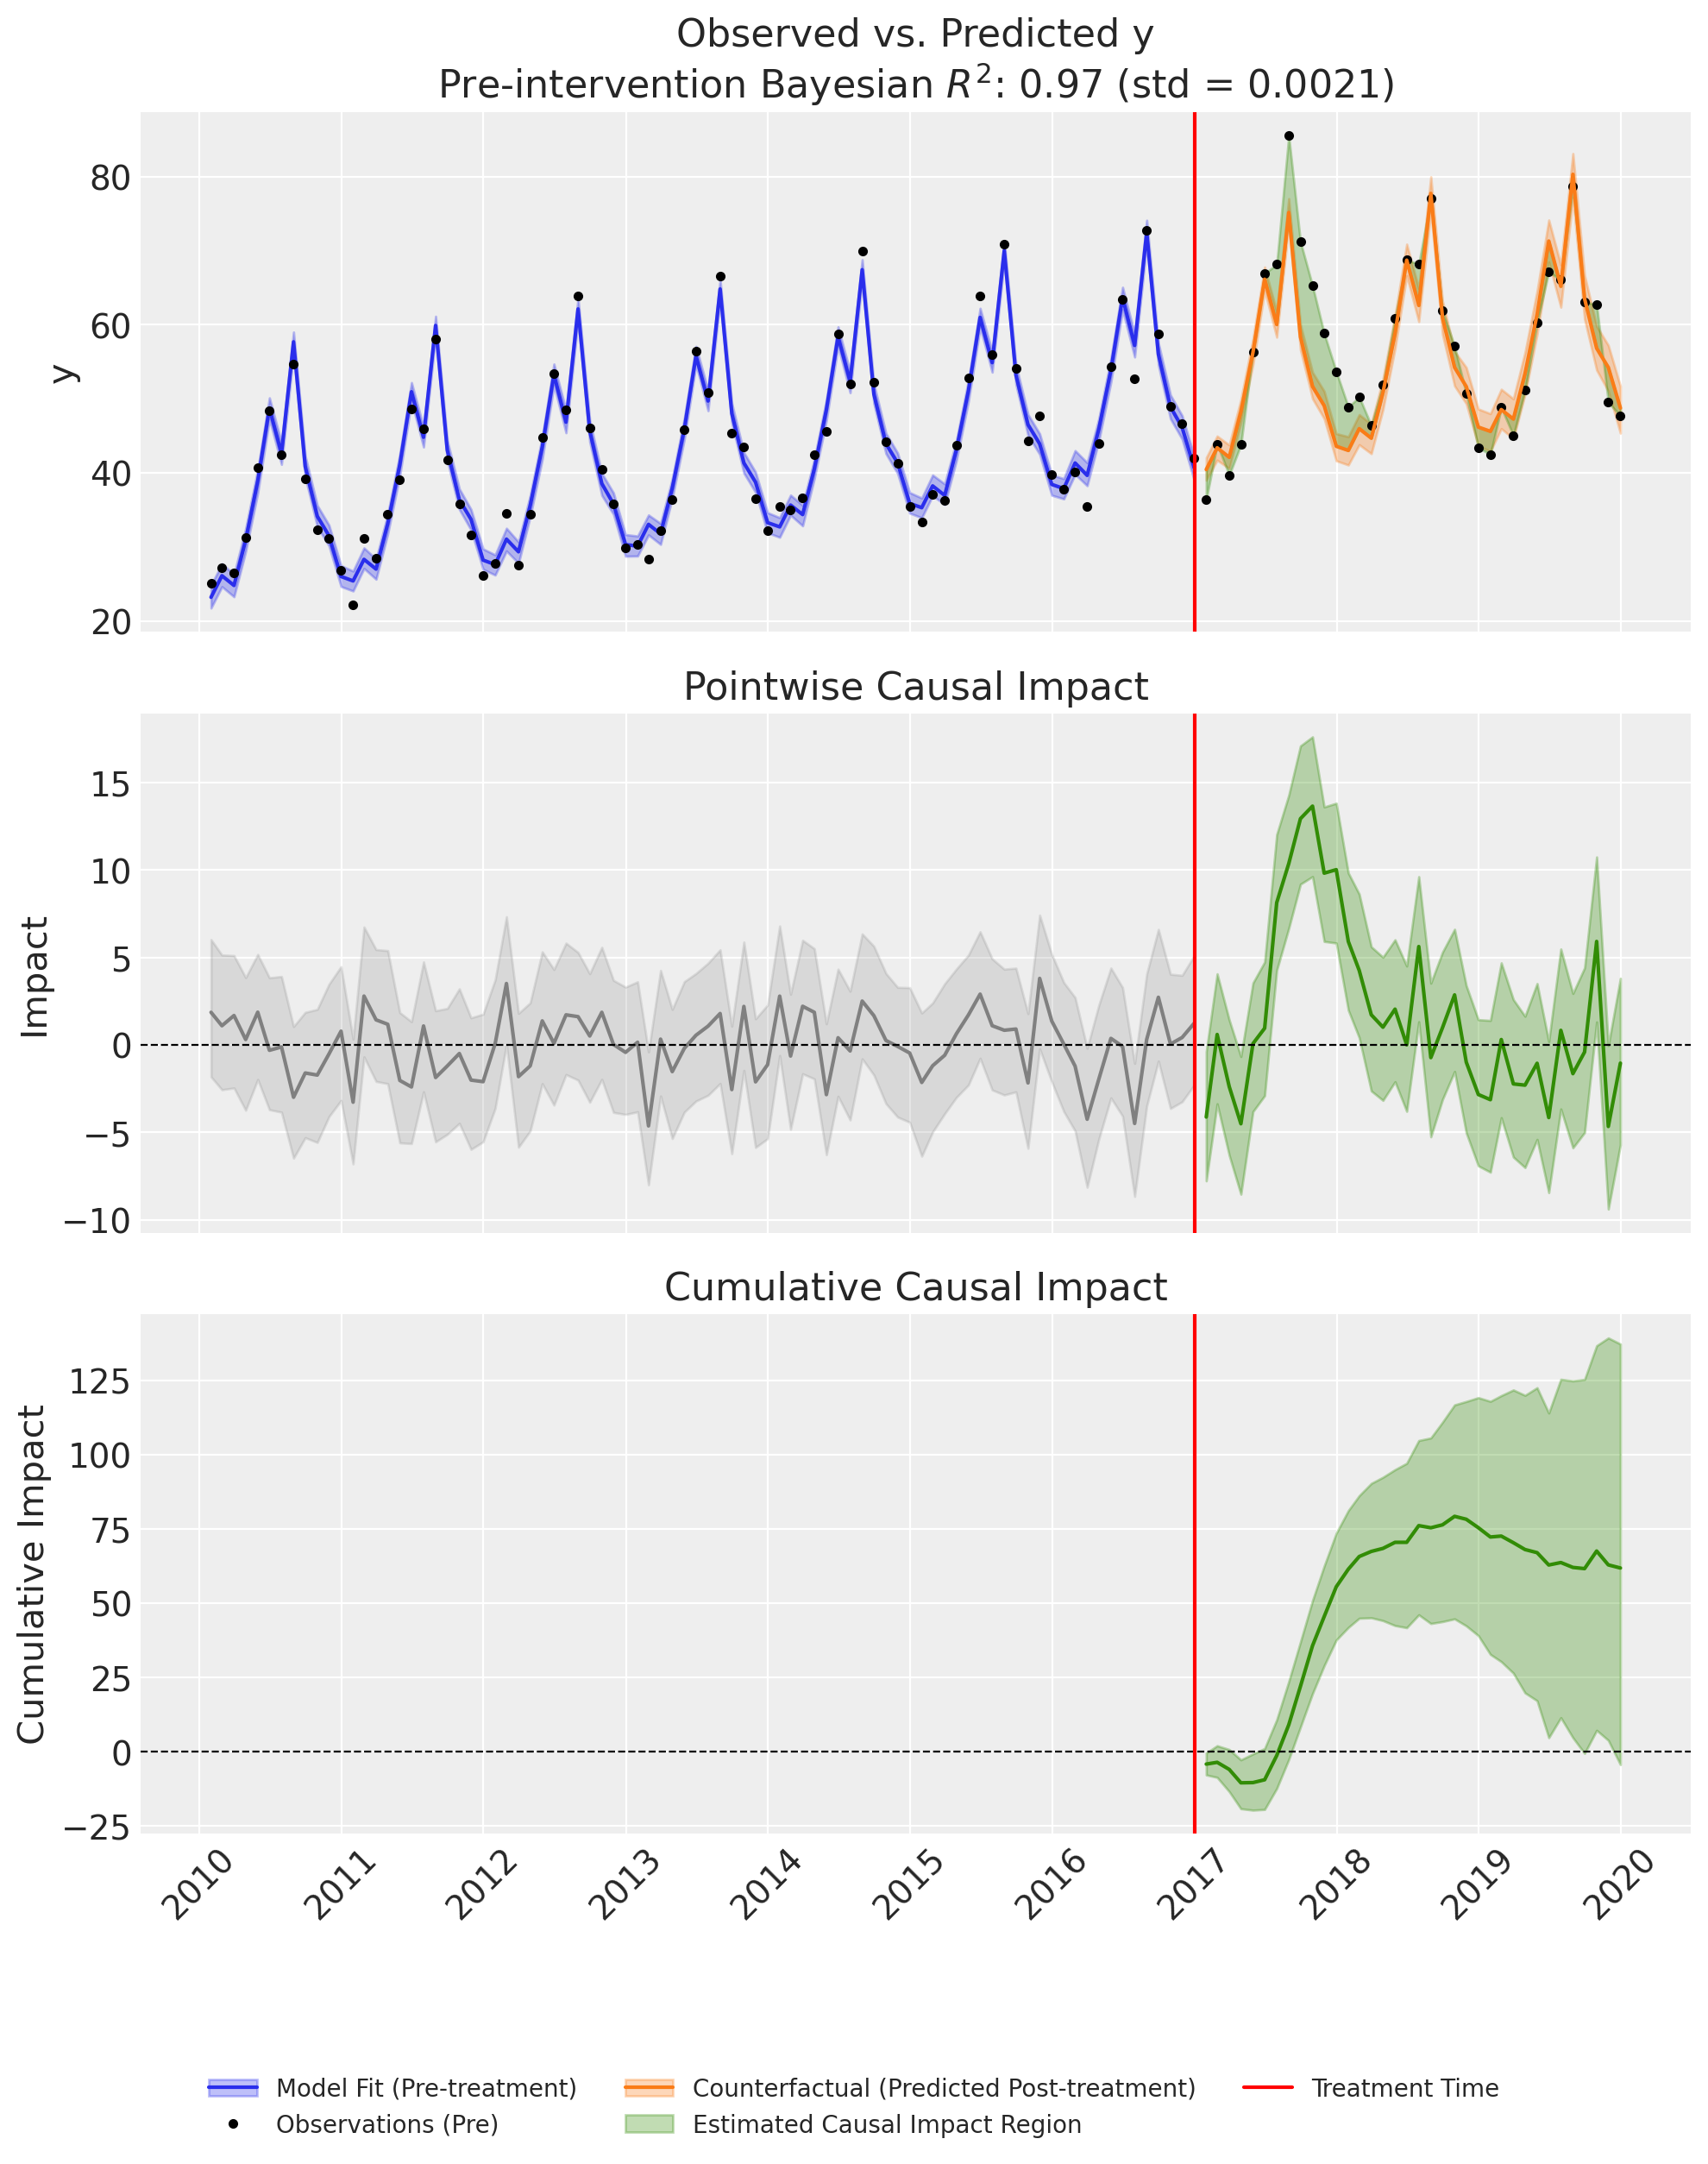

In [22]:
fig, ax = result.plot()

In [23]:
result.summary()

===========================Structured Time Series Fit===========================
Formula: y ~ 1

Model coefficients (Exogenous Regressors and Error Sigma):
Model coefficients:
    Intercept  35, 94% HDI [34, 36]
    sigma      1.8, 94% HDI [1.6, 2.1]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [16]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.929,1.749,-1.402,5.141,0.049,0.045,1278.0,1130.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [17]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,69.444,62.959,-50.48,185.069,1.761,1.632,1278.0,1130.0,1.0
